In [18]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

Text(0.5, 0, 'Time (s)')

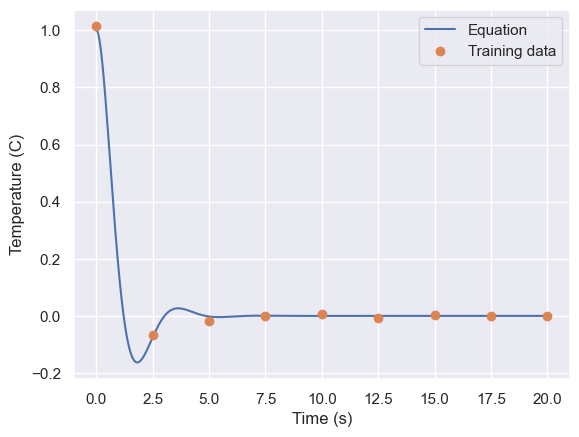

In [19]:
np.random.seed(10)

# Parameters
m = 1.0      # mass (kg)
k = 4.0      # spring constant (N/m)
c = 2.0      # damping constant (N s/m)
x0 = 1.0     # initial position (m)
v0 = 0.0     # initial velocity (m/s)

times = np.linspace(0, 20, 1000)
eq = functools.partial(spring_mass_system, m=m, k=k, c=c, x0=x0, v0=v0)
temps = eq(times)

# Make training data
t = np.linspace(0, 20, 9)
x = eq(t) +  0.01 * np.random.randn(9)

plt.plot(times, temps)
plt.plot(t, x, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [20]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 20, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    # For the spring-mass-damper system: m * d2x/dt2 + c * dx/dt + k * x = 0
    dx = torch.autograd.grad(xs, ts, grad_outputs=torch.ones_like(xs), create_graph=True)[0]
    d2x = torch.autograd.grad(dx, ts, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    pde = m * d2x + c * dx + k * xs
    return torch.mean(pde**2)

Epoch 0/30000, loss: 0.26
Epoch 3000/30000, loss: 0.00
Epoch 6000/30000, loss: 0.00
Epoch 9000/30000, loss: 0.00
Epoch 12000/30000, loss: 0.00
Epoch 15000/30000, loss: 0.00
Epoch 18000/30000, loss: 0.00
Epoch 21000/30000, loss: 0.00
Epoch 24000/30000, loss: 0.00
Epoch 27000/30000, loss: 0.00


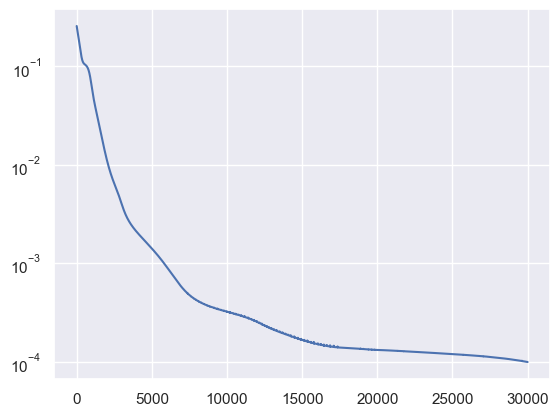

In [21]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=0.1, lr=1e-4, n_units=5).to(DEVICE)

losses = net.fit(t, x)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

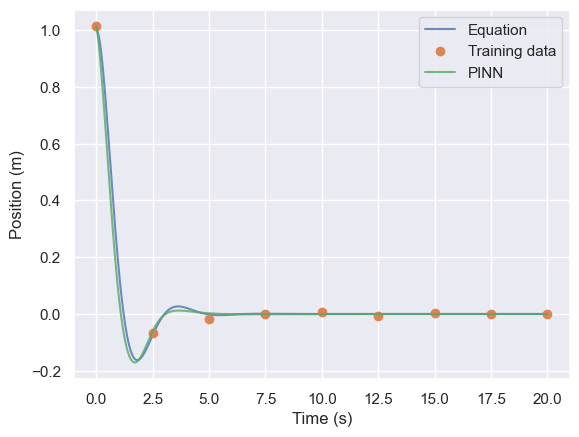

In [23]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, x, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')